In [2]:
from Fisher_models import *

import torch
import torch.nn as nn
import torch.nn.functional as F

from neurodiffeq import diff
from neurodiffeq.neurodiffeq import unsafe_diff as unsafe_diff
from neurodiffeq.conditions import IVP, DirichletBVP, DirichletBVP2D, BundleIVP, BundleDirichletBVP
from neurodiffeq.solvers import Solver1D, Solver2D, BundleSolver1D
from neurodiffeq.networks import FCNN, SinActv
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.generators import Generator1D, Generator2D

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import time as time
from tqdm.auto import tqdm

import matplotlib.cm as cm
from matplotlib.colors import Normalize

from matplotlib.ticker import ScalarFormatter

/Users/wanzhoulei/mambaforge/envs/py3.11/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [3]:
def plot_solutions16(solutions, title = None, savfig = None, figsize=(16, 3.5), subtitle_list = None, dpi=400):
  ##plot the 16 solutions
  fig, ax = plt.subplots(2, 8, figsize=figsize);

  for i in range(16):
    global_min = solutions[i].min()
    global_max = solutions[i].max()
    j = i // 8
    k = i % 8
    # Create color map
    cmap = plt.get_cmap('viridis');  # You can choose any colormap you prefer
    # Create colorbar
    im = ax[j][k].imshow(solutions[i][::-1, :], cmap=cmap, vmin=global_min, vmax=global_max);
    ax[j][k].axis('off')
    cbar = fig.colorbar(im, ax=ax[j][k], shrink=0.9, aspect=8)
    cbar.ax.tick_params(labelsize=6)
    if subtitle_list:
      ax[j][k].set_title(subtitle_list[i],
                         fontdict={'family': 'serif', 'color':  'darkred', 'weight': 'bold', 'size': 10})
  if title:
      plt.suptitle(title);
  plt.subplots_adjust(top=0.93)
  if savfig is not None:
    plt.savefig(savfig, dpi=dpi)

## Load the pre-trained Model

In [4]:
##construct a model of 12 heads
k= 16
model = Multihead_model(k=k, act = nn.functional.silu, bias=True)

In [5]:
##load the model
import pickle
path = 'experiment_log/Fisher_16head_model_dec25_trig_1phase.pickle'
with open(path, 'rb') as f:
  model = pickle.load(f)

In [6]:
model

Multihead_model(
  (linear1): Linear(in_features=2, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=512, bias=True)
  (final_layers): ModuleList(
    (0-15): 16 x Linear(in_features=256, out_features=1, bias=True)
  )
)

## Load or Compute the H matrices

In [7]:
##define the interior set used to do transfer learning on cpu
x, t, interior_tensor = generate_interior_tensor(I=60, require_grad = False)
##define the boundary set used to do transfer learing on cpu
x_boundary, t_boundary, boundary_tensor = generate_boundary_tensor(B=200, require_grad=False, method='equally-spaced')

In [11]:
##compute all the H matrices
bias=True
H_dict = compute_H_dict(model, I=60, B=200, bias=bias)

Differentiating H w.r.t. x now...
Finished computing Hx.
Differentiating H w.r.t. t now...
Finished computing Ht
Differentiating H_b w.r.t. x now...
Finished computing Hx_b.
Differentiating H_b w.r.t. t now...
Finished computing Ht_b


In [14]:
##save all the Hs in files
import pickle
path = 'experiment_log/Fisher_16head_H_dict_dec25_trig_cpu.pickle'
file = open(path, 'wb')
pickle.dump(H_dict, file)
file.close()

In [8]:
##load all the Hs in files
import pickle
path = 'experiment_log/Fisher_16head_H_dict_dec25_trig_cpu.pickle'
file = open(path, 'rb')
H_dict = pickle.load(file)
file.close()

In [9]:
##compute the M and Minv matrices
%time
M, Minv = compute_M(H_dict)
print(M.shape)
print("Condition Number: ", np.linalg.cond(M))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs
(257, 257)
Condition Number:  15224011095.022799


In [10]:
## compute the H matrix evaluated on X_grid for evaluation
_, H  = model(X_grid)
##detach the H
H = H.detach().numpy() #shape (I, 3W)
H = H.reshape(2*H.shape[0], -1) #transform all H into shape (3I, W)
bias = True
if bias: H = np.hstack((H, np.ones((H.shape[0], 1))))

## Test One-shot TL on the 16 heads used to train the model

In [11]:
k1 = 2
K2 = np.linspace(1, 2, 8)
A_list = [0.5, -0.5]; b = 0.5; k=16

truth_functions = []; Forcing_functions = []

for k2 in K2:
  for A in A_list:
    truth_functions.append(truth_decorator_trig(A, k1, k2, b=b))
    Forcing_functions.append(forcing_decorator_trig(A, k1, k2, D=1))

#compute the truth solution
truth_solution = [truth_functions[i](X_grid[:,0],
                            X_grid[:,1]).cpu().detach().numpy().reshape(round(X_grid.shape[0]**.5), -1) for i in range(k)]

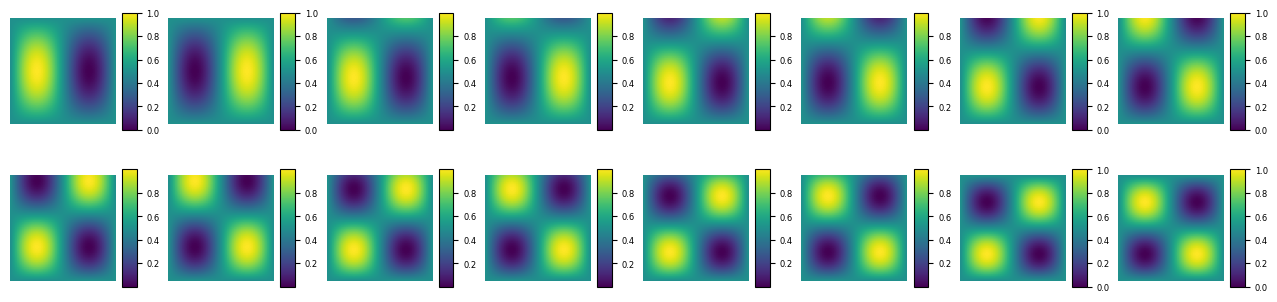

In [12]:
plot_solutions16(truth_solution, savfig = "Truth_16heads.png")

In [19]:
truth_solution = np.array(truth_solution)

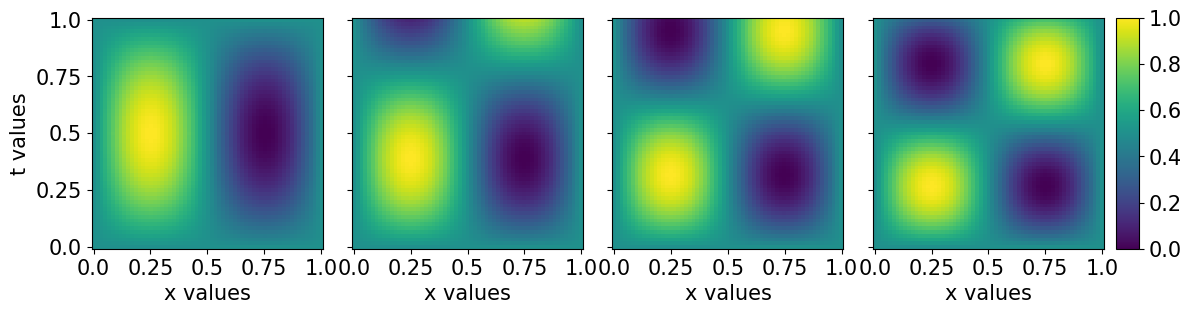

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3), sharey=True);
# Create color map
cmap = plt.get_cmap('viridis');  # You can choose any colormap you prefer
# Create colorbar
global_min = min([truth.min() for truth in truth_solution[[0, 4, 8, 12]]])
global_max = max([truth.max() for truth in truth_solution[[0, 4, 8, 12]]])
normalizer = Normalize(global_min, global_max)
im = cm.ScalarMappable(norm=normalizer)

for i in range(4):
    ax[i].imshow(truth_solution[4*i][::-1, :], cmap=cmap, norm=normalizer);
    ax[i].set_xlabel("x values", fontsize=15);
    ax[i].set_xticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5), fontsize=15)
ax[0].set_ylabel('t values', fontsize=15);
ax[0].set_yticks(np.linspace(0, 60, 5), np.linspace(1, 0, 5), fontsize=15)
plt.subplots_adjust(wspace=0.0)

cbar = fig.colorbar(im, ax=ax.ravel().tolist(), pad=0.01, aspect=10);
cbar.ax.tick_params(labelsize=15)
plt.savefig('4_heads_Fisher.png', dpi=500,  bbox_inches='tight')

Relative Erorr:  0.0016998281259900665
Mean Loss over all Heads:  5.167120755464607e-05


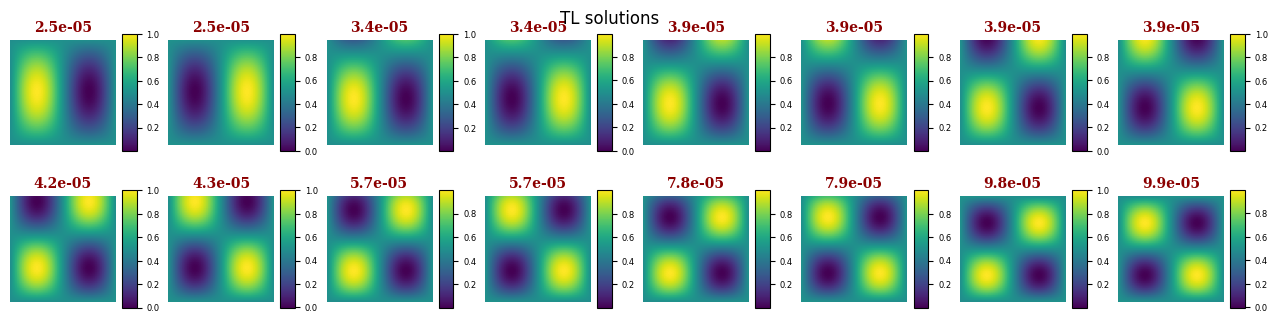

In [21]:
##compute and plot the TL solutions on the 16 heads
Images = []; Poisson_losses = []
for i, force in enumerate(Forcing_functions):
  W = compute_TLW(b, force, Minv, H_dict, x, t)
  image = compute_solution(H, W, I=61)
  Poisson_losses.append(after_loss(H_dict, W, force, b, x, t))
  Images.append(image)
print("Relative Erorr: ", relative_error(Images, truth_solution))
print("Mean Loss over all Heads: ", np.mean(Poisson_losses))

plot_solutions16(Images, "TL solutions", savfig = None, subtitle_list = [round(l, 6) for l in Poisson_losses])

 # Try un-seen parameters

 Fix everything except for K2. k2 had these values when training: [1., 1.14285714, 1.28571429, 1.42857143, 1.57142857, 1.71428571, 1.85714286, 2.]. Let's just take the middle shift.

In [20]:
K2_new = K2 + (K2[1]-K2[0])/2

In [21]:
truth_functions_new = []; Forcing_functions_new = []

for k2 in K2_new:
  for A in A_list:
    truth_functions_new.append(truth_decorator_trig(A, k1, k2, b=b))
    Forcing_functions_new.append(forcing_decorator_trig(A, k1, k2, D=1))

#compute the truth solution
truth_solution_new = [truth_functions_new[i](X_grid[:,0],
                            X_grid[:,1]).cpu().detach().numpy().reshape(round(X_grid.shape[0]**.5), -1) for i in range(k)]

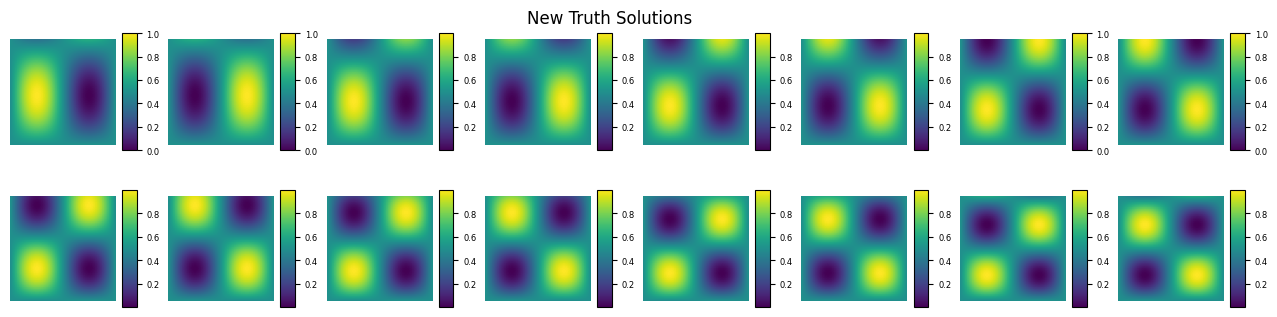

In [22]:
#plot the new truth solution
plot_solutions16(truth_solution_new, "New Truth Solutions")

Relative Erorr from truth:  0.0017757449688415529
Mean Loss over all Heads:  5.7288222109619404e-05


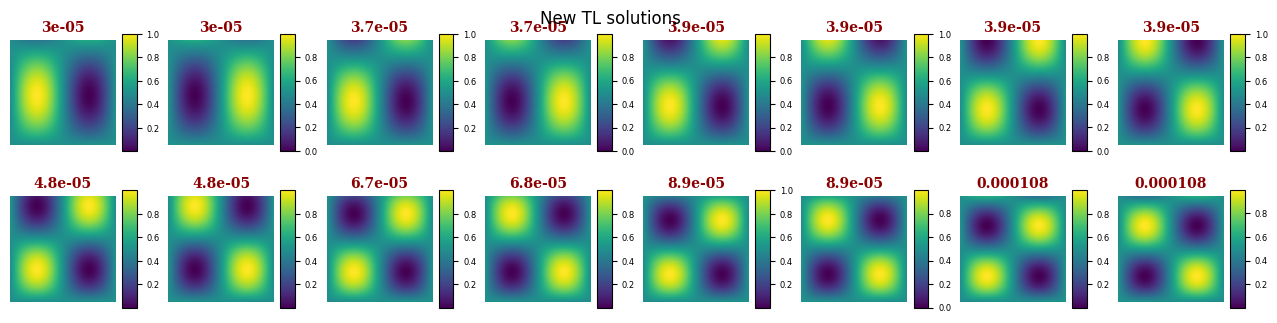

In [23]:
##compute and plot the TL solutions on the 16 heads
Images_new = []; Poisson_losses_new = []
for i, force in enumerate(Forcing_functions_new):
  W = compute_TLW(b, force, Minv, H_dict, x, t)
  image = compute_solution(H, W, I=61)
  Poisson_losses_new.append(after_loss(H_dict, W, force, b, x, t))
  Images_new.append(image)
print("Relative Erorr from truth: ", relative_error(Images_new, truth_solution_new))
print("Mean Loss over all Heads: ", np.mean(Poisson_losses_new))

plot_solutions16(Images_new, "New TL solutions", savfig = None, subtitle_list = [round(l, 6) for l in Poisson_losses_new])

In [24]:
##vary only k2 to see how the loss varies

K2_list = np.linspace(1, 2, 100)
PoissonLoss_over_k2 = []; A = 0.5
for k2 in tqdm(K2_list):
  #build the forcing function
  force = forcing_decorator_trig(A, k1, k2, D=1)
  #compute the TL W
  W = compute_TLW(b, force, Minv, H_dict, x, t)
  PoissonLoss_over_k2.append(after_loss(H_dict, W, force, b, x, t))

  0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
# vary only b to see how the loss changes
b_list = np.linspace(-1, 1, 200); A = 0.5; k1 = 2; k2 = 1.2

PoissonLoss_over_b = [];
for b in tqdm(b_list):
  #build the forcing function
  force = forcing_decorator_trig(A, k1, k2, D=1)
  #compute the TL W
  W = compute_TLW(b, force, Minv, H_dict, x, t)
  PoissonLoss_over_b.append(after_loss(H_dict, W, force, b, x, t))

  0%|          | 0/200 [00:00<?, ?it/s]

In [26]:
# only vary A to see how the loss goes
k1 = 2; k2 = 1.2; b = 0.5
A_list_new = np.linspace(-1, 1, 100)

PoissonLoss_over_A = [];
for A in tqdm(A_list_new):
  #build the forcing function
  force = forcing_decorator_trig(A, k1, k2, D=1)
  #compute the TL W
  W = compute_TLW(b, force, Minv, H_dict, x, t)
  PoissonLoss_over_A.append(after_loss(H_dict, W, force, b, x, t))

  0%|          | 0/100 [00:00<?, ?it/s]

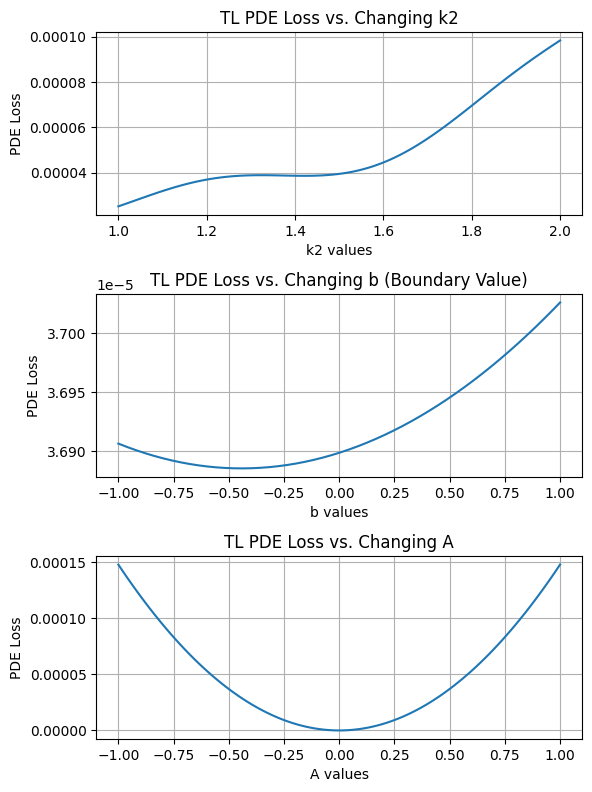

In [27]:
fig, ax = plt.subplots(3, 1, figsize=(6, 8))
ax[0].plot(K2_list, PoissonLoss_over_k2)
ax[0].set_xlabel("k2 values");
ax[0].set_ylabel("PDE Loss");
ax[0].set_title("TL PDE Loss vs. Changing k2");
ax[0].grid();
ax[1].plot(b_list, PoissonLoss_over_b)
ax[1].set_xlabel("b values");
ax[1].set_ylabel("PDE Loss");
ax[1].set_title("TL PDE Loss vs. Changing b (Boundary Value)");
ax[1].grid();
ax[2].plot(A_list_new, PoissonLoss_over_A)
ax[2].set_xlabel("A values");
ax[2].set_ylabel("PDE Loss");
ax[2].set_title("TL PDE Loss vs. Changing A");
ax[2].grid();
fig.tight_layout(pad=1.0)

## Fisher's Equation with Zero forcing functions and constant bonudary and initial conditions

In [28]:
p = 12
result_list = []; Fisher_loss_list = []
for r in tqdm([0.4, 0.5, 0.6, 0.7]):
  for b in [0.2, 0.4, 0.6, 0.8]:
    force = lambda x, t: torch.zeros((3600, 1))
    f0_values = torch.zeros((3600, 1))
    result = Fisher_solver(H_dict, Minv, f0_values, b, r, H, p=p)
    result_list.append(result)
    Fisher_loss_list.append(Fisher_loss(model, result['W'], r, force, b0=b))

  0%|          | 0/4 [00:00<?, ?it/s]

Average Fisher's Loss:  0.0001024767394556353


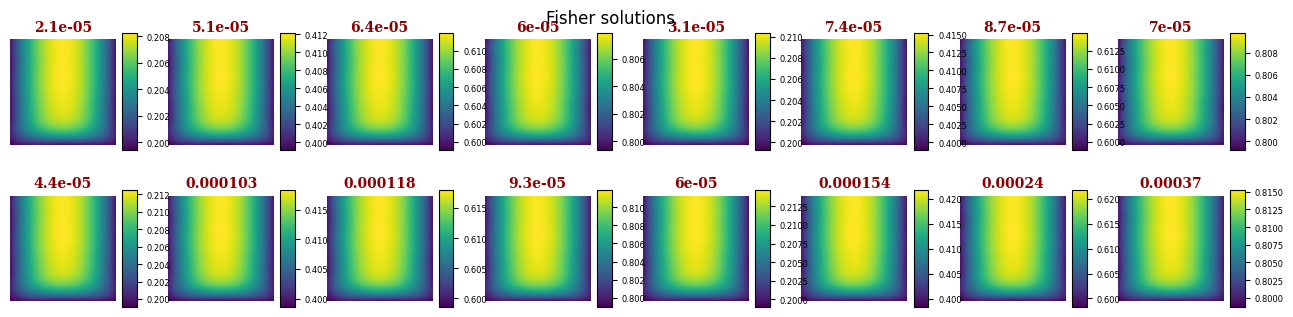

In [29]:
plot_solutions16([result['sol'] for result in result_list], 'Fisher solutions',
                  subtitle_list = [round(l['total_loss'], 6) for l in Fisher_loss_list])
print("Average Fisher's Loss: ", np.mean([l['total_loss'] for l in Fisher_loss_list]))

### In this scenario, let's see how the loss changes w.r.t. r and b

In [29]:
R = np.linspace(0.1, 0.9, 20); p = 12
##fix b at 0.5
Fisher_loss_r = []
for r in tqdm(R):
  force = lambda x, t: torch.zeros((3600, 1))
  f0_values = torch.zeros((3600, 1))
  result = Fisher_solver(H_dict, Minv, f0_values, 0.5, r, H, p=p)
  Fisher_loss_r.append(Fisher_loss(model, result['W'], r, force, b0=0.5))

  0%|          | 0/20 [00:00<?, ?it/s]

In [30]:
B = np.linspace(0.2, 0.8, 20); p = 12
##fix r at 0.5
Fisher_loss_b = []
for b in tqdm(B):
  force = lambda x, t: torch.zeros((3600, 1))
  f0_values = torch.zeros((3600, 1))
  result = Fisher_solver(H_dict, Minv, f0_values, b, 0.5, H, p=p)
  Fisher_loss_b.append(Fisher_loss(model, result['W'], 0.5, force, b0=b))

  0%|          | 0/20 [00:00<?, ?it/s]

In [31]:
##fix b = 0.5 and r = 0.5 and vary p
P = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Fisher_loss_p = []
for p in tqdm(P):
  force = lambda x, t: torch.zeros((3600, 1))
  f0_values = torch.zeros((3600, 1))
  result = Fisher_solver(H_dict, Minv, f0_values, 0.5, 0.5, H, p=p)
  Fisher_loss_p.append(Fisher_loss(model, result['W'], 0.5, force, b0=0.5))

  0%|          | 0/12 [00:00<?, ?it/s]

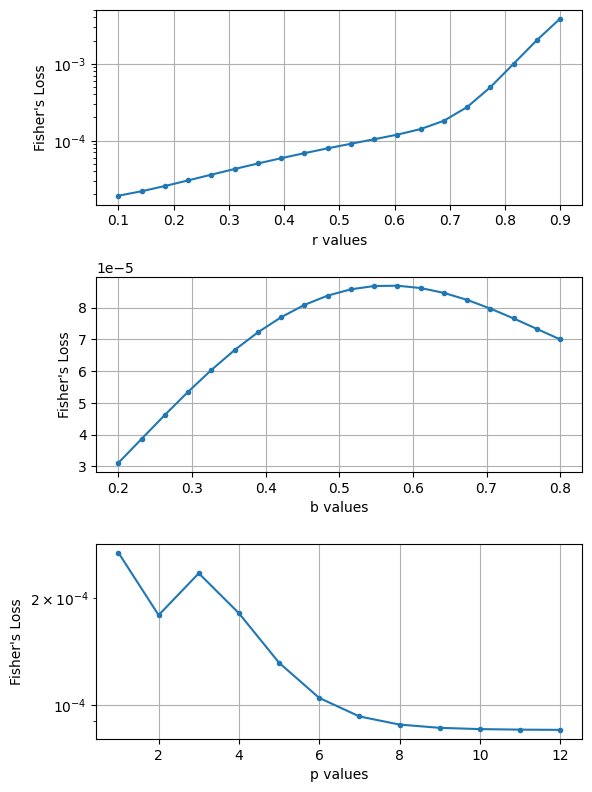

In [33]:
fig, ax = plt.subplots(3, 1, figsize=(6, 8));
ax[0].set_yscale('log');
ax[0].plot(R, [l['total_loss'] for l in Fisher_loss_r], '.-');
ax[0].grid();
ax[0].set_xlabel("r values");
ax[0].set_ylabel("Fisher's Loss");

ax[1].plot(B, [l['total_loss'] for l in Fisher_loss_b], '.-');
ax[1].grid();
ax[1].set_xlabel('b values');
ax[1].set_ylabel("Fisher's Loss");

ax[2].plot(P, [l['total_loss'] for l in Fisher_loss_p], '.-');
ax[2].set_yscale('log');
ax[2].set_xlabel("p values");
ax[2].set_ylabel("Fisher's Loss");
ax[2].grid();
fig.tight_layout(pad=1.0)

# Non-zero forcing functions

try
$$f(x, t) = Asin(2 \pi x) sin(k2 \pi t)$$

With constant boundary condition fixed at 0.5.

In [30]:
A_list = [0.25, 0.5, 0.75, 1]; k1 = 2; p = 30
k2_list = np.linspace(1, 2, 4); b = 0.5; r = 0.5
result_list = []; Fisher_loss2 = []
for A in tqdm(A_list):
  for k2 in k2_list:
    force = truth_decorator_trig(A, k1, k2)
    f0_values = force(x, t).detach().numpy()
    result = Fisher_solver(H_dict, Minv, f0_values, b, r, H, p=p)
    result_list.append(result)
    Fisher_loss2.append(Fisher_loss(model, result['W'], r, force, b0=b))

  0%|          | 0/4 [00:00<?, ?it/s]

Average Fisher's Loss:  9.358184105481058e-05
Average Relative PDE loss:  0.03316584161697167
Average Relative BC loss:  1.333846686239354e-07


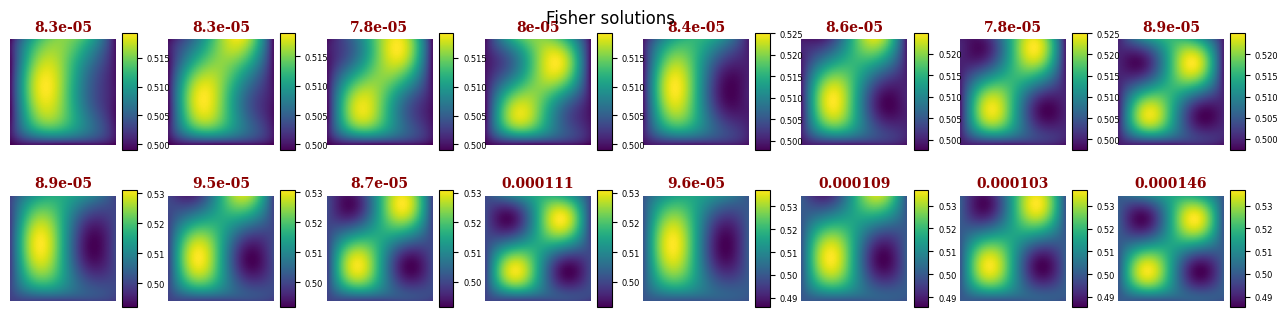

In [31]:
plot_solutions16([result['sol'] for result in result_list], 'Fisher solutions',
                  subtitle_list = [round(l['total_loss'], 6) for l in Fisher_loss2])
print("Average Fisher's Loss: ", np.mean([l['total_loss'] for l in Fisher_loss2]))
print("Average Relative PDE loss: ", np.mean([l['relative_pde_loss'] for l in Fisher_loss2]))
print("Average Relative BC loss: ", np.mean([l['relative_bc_loss'] for l in Fisher_loss2]))

### See how the average Fisher loss decreases as p increase.

In [32]:
P = range(1, 31); Fisher_loss_p = []; Result_List = []; Fisher_loss_relativepde = []
for p in tqdm(P):
  A_list = [0.25, 0.5, 0.75, 1]; k1 = 2;
  k2_list = np.linspace(1, 2, 4); b = 0.5; r = 0.5
  Fisher_loss_list = []; result_list = [];
  for A in A_list:
    for k2 in k2_list:
      force = truth_decorator_trig(A, k1, k2)
      f0_values = force(x, t).detach().numpy()
      result = Fisher_solver(H_dict, Minv, f0_values, b, r, H, p=p)
      Fisher_loss_list.append(Fisher_loss(model, result['W'], r, force, b0=b))
      result_list.append(result)
  Fisher_loss_p.append(np.mean([l['total_loss'] for l in Fisher_loss_list]))
  Fisher_loss_relativepde.append(np.mean([l['relative_pde_loss'] for l in Fisher_loss_list]))
  Result_List.append(result_list)

  0%|          | 0/30 [00:00<?, ?it/s]

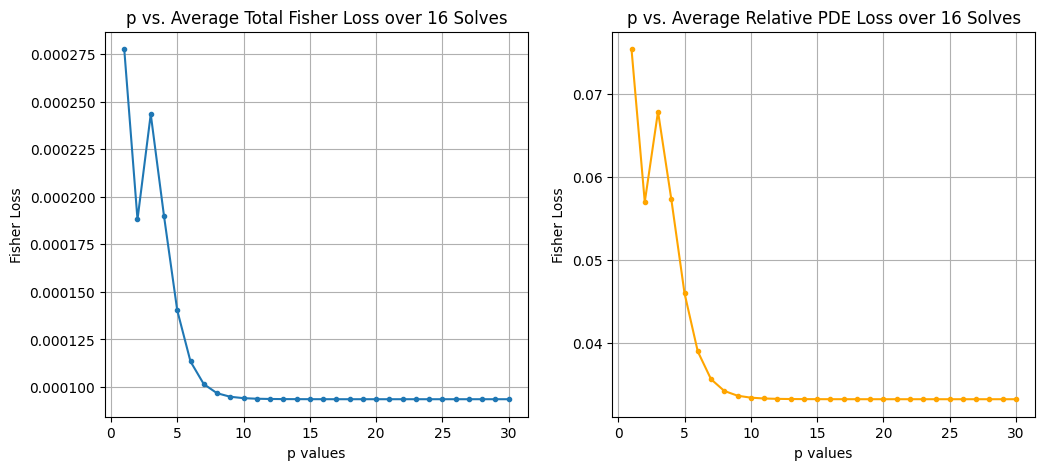

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5));
ax[0].plot(P, Fisher_loss_p, '.-');
ax[0].grid();
ax[0].set_xlabel('p values');
ax[0].set_ylabel("Fisher Loss");
ax[0].set_title("p vs. Average Total Fisher Loss over 16 Solves");

ax[1].plot(P, Fisher_loss_relativepde, '.-', c='orange');
ax[1].grid();
ax[1].set_xlabel('p values');
ax[1].set_ylabel("Fisher Loss");
ax[1].set_title("p vs. Average Relative PDE Loss over 16 Solves");

## Manufactured solution 
Let's fix 
$$
u(x, t) = Ax(x-1)sin(kt) + b
$$

The corresponding forcig function should be

$$
f(x, t) = Akx(x-1)cos(kt) - 2Asin(kt) - ru(1-u)
$$

In [33]:
def function_decorator3(A, k, b=0):
    def func(x, t):
        return A*x*(x-1)*torch.sin(k*t) + b
    return func

def forcing_decorator3(A, k, r, b=0):
    func = function_decorator3(A, k, b)
    def force(x, t):
        u = func(x, t)
        return A*k*x*(x-1)*torch.cos(k*t) - 2*A*torch.sin(k*t) - r*u*(1-u)
    return force
        

Let's just see an example of what the exact solution and its corresponding forcing function look like.

In [34]:
A = 2; k =2*np.pi + 1; r = 0.5
exact_func = function_decorator3(A, k, b=0.5)
forcing = forcing_decorator3(A, k, r, b=0.5)
exact_values = exact_func(x,t).detach().numpy().reshape(60, -1)
forcing_values = forcing(x, t).detach().numpy().reshape(60, -1)

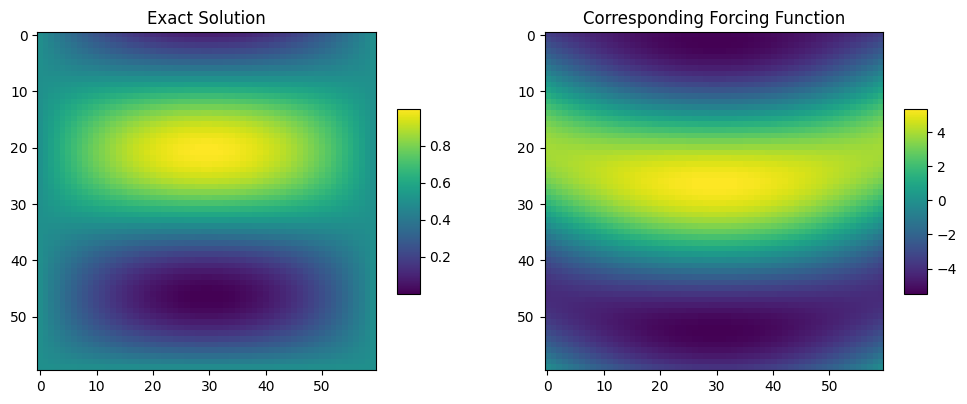

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6));
im0 = ax[0].imshow((exact_values.T)[::-1]);
im1 = ax[1].imshow((forcing_values.T)[::-1]);
cbar0 = fig.colorbar(im0, ax=ax[0], shrink=0.4, aspect=8);
cbar0.ax.tick_params(labelsize=10);
cbar1 = fig.colorbar(im1, ax=ax[1], shrink=0.4, aspect=8);
cbar1.ax.tick_params(labelsize=10);
ax[0].set_title("Exact Solution");
ax[1].set_title("Corresponding Forcing Function");

Let's fix b = 0.5, r = 0.5, vary A from [1, 2] and k from $[\pi, 2\pi]$, using p = 20.

In [36]:
##define the interior set used to do transfer learning on cpu
x, t, interior_tensor = generate_interior_tensor(I=60, require_grad = False)
##define the boundary set used to do transfer learing on cpu
x_boundary, t_boundary, boundary_tensor = generate_boundary_tensor(B=200, require_grad=False, method='equally-spaced')

In [37]:
p = 20; b = 0.5; r = 0.5;
A_list = [1, 2]; K_list = np.linspace(np.pi, 2*np.pi, 8);
manufactured_list = []
perturbation_list = []
Fisher_loss_list = []
mse_list = []

In [38]:
for A in A_list:
    for k in K_list:
        ##compute the Perturbation solutions
        force = forcing_decorator3(A, k, r, b=b)
        f0_values = force(x, t).detach().numpy()
        result = Fisher_solver(H_dict, Minv, f0_values, b, r, H, p=p)
        perturbation_list.append(result['sol'])
        ##compute the truth solutions
        truth_func = function_decorator3(A, k, b=b)
        truth = truth_func(X_grid[:,0], X_grid[:, 1]).reshape(61, -1).detach().numpy()
        manufactured_list.append(truth)
        ##compute mse for each one
        mse_list.append(((truth - result['sol'])**2).mean())
        ##compute the Fisher loss
        Fisher_loss_list.append(Fisher_loss(model, result['W'], r, force, b0=b))

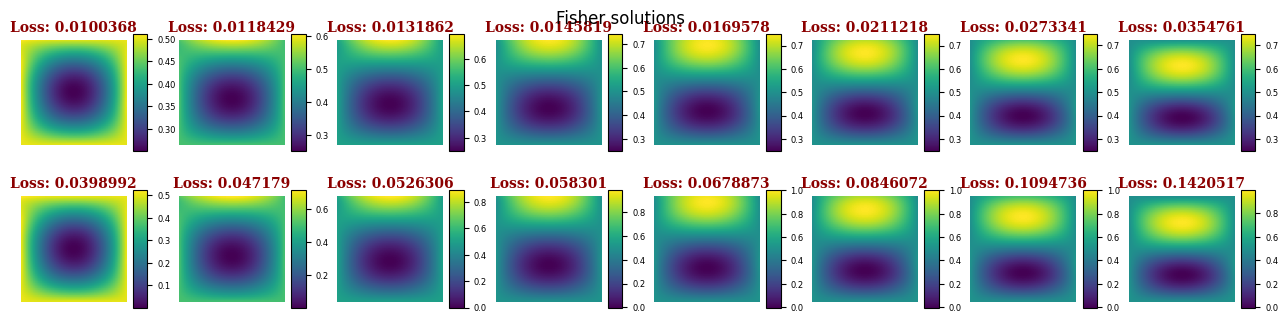

In [39]:
plot_solutions16(perturbation_list, 'Fisher solutions', 
                subtitle_list = ["Loss: " + str(round(l['total_loss'], 7)) for l in Fisher_loss_list]);

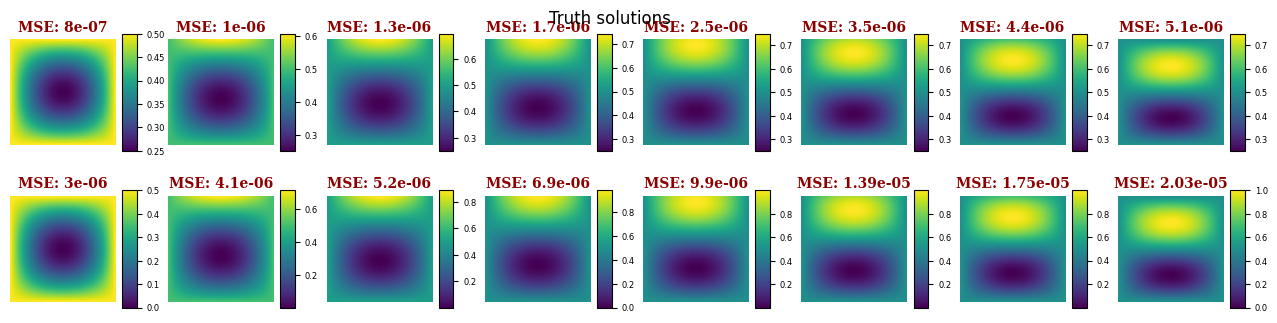

In [40]:
plot_solutions16(manufactured_list, 'Truth solutions', subtitle_list = ["MSE: " + str(round(mse, 7)) for mse in mse_list]);

In [41]:
##print 1. mean fisher loss 2. mean relative pde residual 3. mean BC condition loss 4. mean relative error
print("Average Fisher's Loss: ", np.mean([l['total_loss'] for l in Fisher_loss_list]))
print("Average Relative PDE residual diff: ", np.mean([l['relative_pde_loss'] for l in Fisher_loss_list]))
print("Average Relative BC loss: ", np.mean([l['relative_bc_loss'] for l in Fisher_loss_list]))
relative_error = abs(np.array(perturbation_list) - np.array(manufactured_list)).mean()/abs(np.array(manufactured_list)).mean()
print("Mean relative error: ", relative_error)

Average Fisher's Loss:  0.04703544590939966
Average Relative PDE residual diff:  0.062016398982566834
Average Relative BC loss:  2.5083978981024116e-05
Mean relative error:  0.0041447438488684245


Now change the range of k to $[2\pi, 3\pi]$

In [42]:
p = 20; b = 0.5; r = 0.5;
A_list = [1, 2]; K_list = np.linspace(2*np.pi, 3*np.pi, 8);
manufactured_list = []
perturbation_list = []
Fisher_loss_list = []
mse_list = []

for A in A_list:
    for k in K_list:
        ##compute the Perturbation solutions
        force = forcing_decorator3(A, k, r, b=b)
        f0_values = force(x, t).detach().numpy()
        result = Fisher_solver(H_dict, Minv, f0_values, b, r, H, p=p)
        perturbation_list.append(result['sol'])
        ##compute the truth solutions
        truth_func = function_decorator3(A, k, b=b)
        truth = truth_func(X_grid[:,0], X_grid[:, 1]).reshape(61, -1).detach().numpy()
        manufactured_list.append(truth)
        ##compute mse for each one
        mse_list.append(((truth - result['sol'])**2).mean())
        ##compute the Fisher loss
        Fisher_loss_list.append(Fisher_loss(model, result['W'], r, force, b0=b))

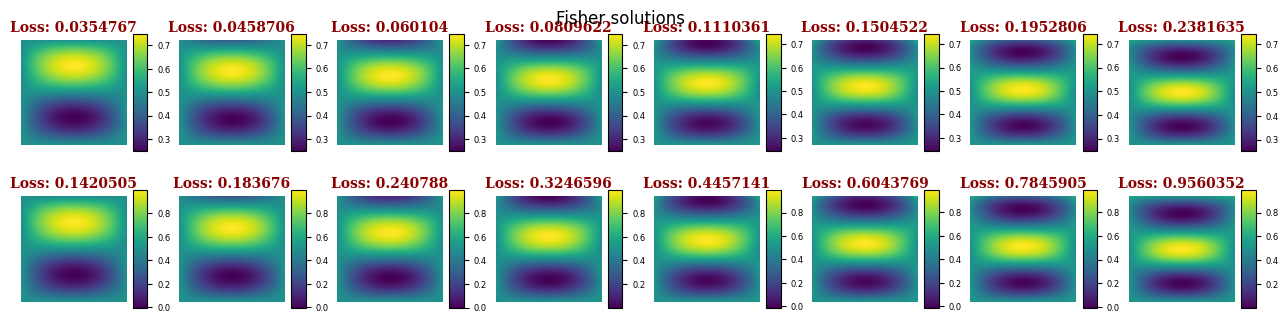

In [43]:
plot_solutions16(perturbation_list, 'Fisher solutions', 
                subtitle_list = ["Loss: " + str(round(l['total_loss'], 7)) for l in Fisher_loss_list]);

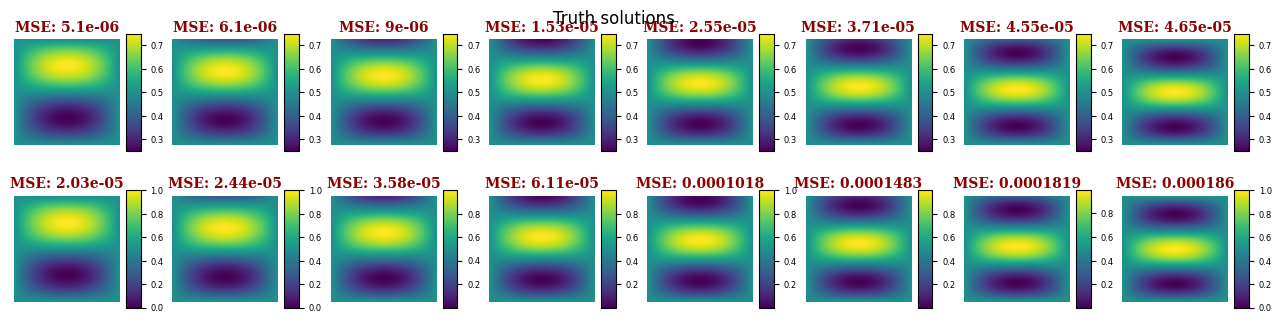

In [44]:
plot_solutions16(manufactured_list, 'Truth solutions', subtitle_list = ["MSE: " + str(round(mse, 7)) for mse in mse_list]);

In [45]:
##print 1. mean fisher loss 2. mean relative pde residual 3. mean BC condition loss 4. mean relative error
print("Average Fisher's Loss: ", np.mean([l['total_loss'] for l in Fisher_loss_list]))
print("Average Relative PDE residual diff: ", np.mean([l['relative_pde_loss'] for l in Fisher_loss_list]))
print("Average Relative BC loss: ", np.mean([l['relative_bc_loss'] for l in Fisher_loss_list]))
relative_error = abs(np.array(perturbation_list) - np.array(manufactured_list)).mean()/abs(np.array(manufactured_list)).mean()
print("Mean relative error: ", relative_error)

Average Fisher's Loss:  0.287452292708618
Average Relative PDE residual diff:  0.12812190851485683
Average Relative BC loss:  0.00020186436218061352
Mean relative error:  0.011386752822720714


change the range of k to $[3\pi, 4\pi]$

In [46]:
p = 20; b = 0.5; r = 0.5;
A_list = [1, 2]; K_list = np.linspace(3*np.pi, 4*np.pi, 8);
manufactured_list = []
perturbation_list = []
Fisher_loss_list = []
mse_list = []

for A in A_list:
    for k in K_list:
        ##compute the Perturbation solutions
        force = forcing_decorator3(A, k, r, b=b)
        f0_values = force(x, t).detach().numpy()
        result = Fisher_solver(H_dict, Minv, f0_values, b, r, H, p=p)
        perturbation_list.append(result['sol'])
        ##compute the truth solutions
        truth_func = function_decorator3(A, k, b=b)
        truth = truth_func(X_grid[:,0], X_grid[:, 1]).reshape(61, -1).detach().numpy()
        manufactured_list.append(truth)
        ##compute mse for each one
        mse_list.append(((truth - result['sol'])**2).mean())
        ##compute the Fisher loss
        Fisher_loss_list.append(Fisher_loss(model, result['W'], r, force, b0=b))

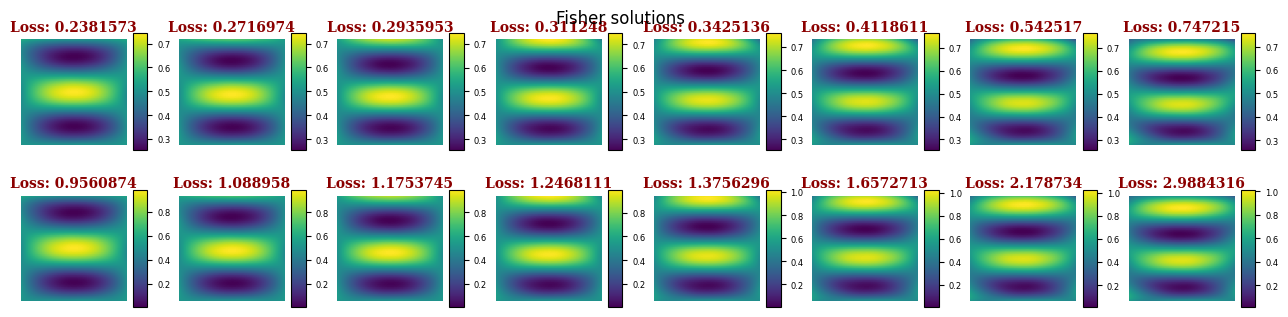

In [47]:
plot_solutions16(perturbation_list, 'Fisher solutions', 
                subtitle_list = ["Loss: " + str(round(l['total_loss'], 7)) for l in Fisher_loss_list]);

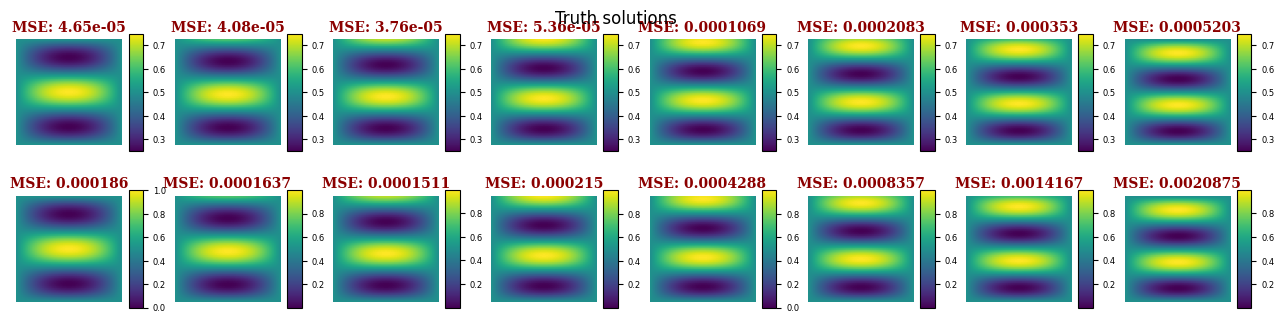

In [48]:
plot_solutions16(manufactured_list, 'Truth solutions', subtitle_list = ["MSE: " + str(round(mse, 7)) for mse in mse_list]);

In [49]:
##print 1. mean fisher loss 2. mean relative pde residual 3. mean BC condition loss 4. mean relative error
print("Average Fisher's Loss: ", np.mean([l['total_loss'] for l in Fisher_loss_list]))
print("Average Relative PDE residual diff: ", np.mean([l['relative_pde_loss'] for l in Fisher_loss_list]))
print("Average Relative BC loss: ", np.mean([l['relative_bc_loss'] for l in Fisher_loss_list]))
relative_error = abs(np.array(perturbation_list) - np.array(manufactured_list)).mean()/abs(np.array(manufactured_list)).mean()
print("Mean relative error: ", relative_error)

Average Fisher's Loss:  0.9891313891193011
Average Relative PDE residual diff:  0.2168110893911145
Average Relative BC loss:  0.0014150743679277925
Mean relative error:  0.0308439294660745


### Manufactured Solution2
Now use the folloing manufactured solution:

$$
u(x, t) = Ax(x-\zeta)(x-1)sin(kt) + b
$$

With the corresponding forcing function:

$$
f(x, t) = kAx(x-\zeta)(x-1)cos(kt) - A(6x - 2(1+\zeta))sin(kt) - ru(1-u)
$$

In [13]:
def function_decorator4(A, zeta, k, b=0):
    def func(x, t):
        return A*x*(x-zeta)*(x-1)*torch.sin(k*t)+ b
    return func

def forcing_decorator4(A, zeta, k, r, b=0):
    func = function_decorator4(A, zeta, k, b=b)
    def force(x, t):
        dudt = k*A*x*(x-zeta)*(x-1)*torch.cos(k*t)
        dudxx = A*(6*x - 2*(1+zeta))*torch.sin(k*t)
        u = func(x, t)
        return dudt - dudxx - r*u*(1-u)
    return force

In [14]:
A = 0.3; k =2*np.pi + 1; r = 0.9; zeta = 0.4
exact_func = function_decorator4(A, zeta, k, b=0.5)
forcing = forcing_decorator4(A, zeta, k, r, b=0.5)
exact_values = exact_func(x,t).detach().numpy().reshape(60, -1)
forcing_values = forcing(x, t).detach().numpy().reshape(60, -1)

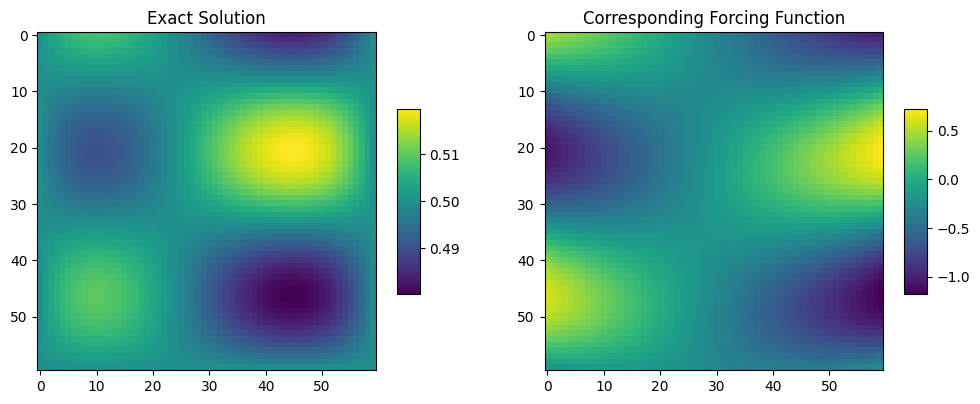

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6));
im0 = ax[0].imshow((exact_values.T)[::-1]);
im1 = ax[1].imshow((forcing_values.T)[::-1]);
cbar0 = fig.colorbar(im0, ax=ax[0], shrink=0.4, aspect=8);
cbar0.ax.tick_params(labelsize=10);
cbar1 = fig.colorbar(im1, ax=ax[1], shrink=0.4, aspect=8);
cbar1.ax.tick_params(labelsize=10);
ax[0].set_title("Exact Solution");
ax[1].set_title("Corresponding Forcing Function");

In [16]:
zeta_list = np.linspace(0.4, 0.6, 4)
K_list = np.linspace(np.pi, 2*np.pi, 4)
p = 20; b = 0.5; r = 0.8; A = 4;
manufactured_list = []
perturbation_list = []
Fisher_loss_list = []
mse_list = []

for zeta in zeta_list:
    for k in K_list:
        ##compute the Perturbation solutions
        force = forcing_decorator4(A, zeta, k, r, b=b)
        f0_values = force(x, t).detach().numpy()
        result = Fisher_solver(H_dict, Minv, f0_values, b, r, H, p=p)
        perturbation_list.append(result['sol'])
        ##compute the truth solutions
        truth_func = function_decorator4(A, zeta, k, b=b)
        truth = truth_func(X_grid[:,0], X_grid[:, 1]).reshape(61, -1).detach().numpy()
        manufactured_list.append(truth)
        ##compute mse for each one
        mse_list.append(((truth - result['sol'])**2).mean())
        ##compute the Fisher loss
        Fisher_loss_list.append(Fisher_loss(model, result['W'], r, force, b0=b))

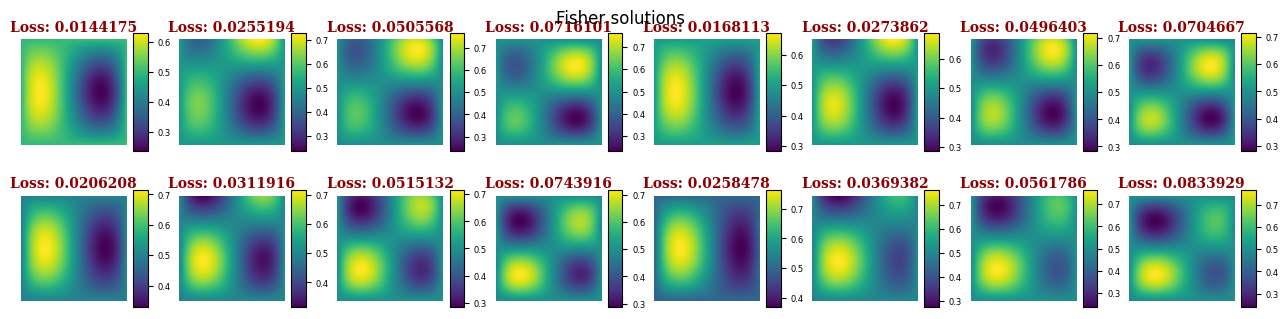

In [17]:
plot_solutions16(perturbation_list, 'Fisher solutions', 
                subtitle_list = ["Loss: " + str(round(l['total_loss'], 7)) for l in Fisher_loss_list]);

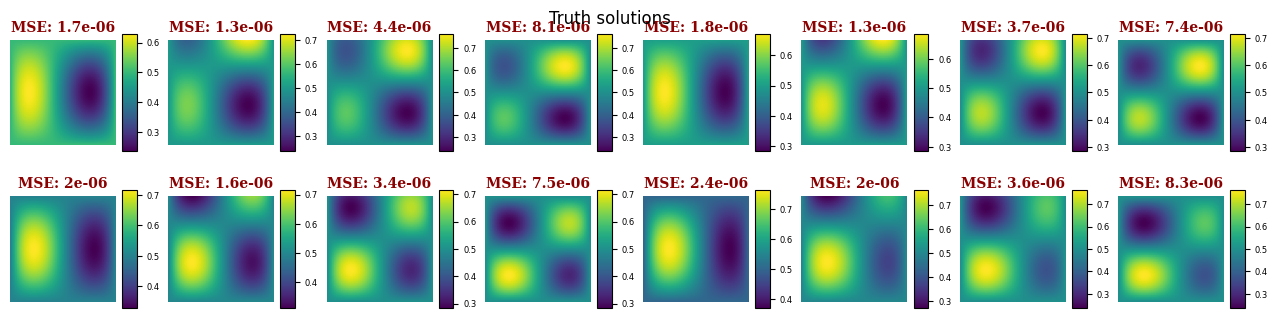

In [18]:
plot_solutions16(manufactured_list, 'Truth solutions', subtitle_list = ["MSE: " + str(round(mse, 7)) for mse in mse_list]);

In [19]:
##print 1. mean fisher loss 2. mean relative pde residual 3. mean BC condition loss 4. mean relative error
print("Average Fisher's Loss: ", np.mean([l['total_loss'] for l in Fisher_loss_list]))
print("Average Relative PDE residual diff: ", np.mean([l['relative_pde_loss'] for l in Fisher_loss_list]))
print("Average Relative BC loss: ", np.mean([l['relative_bc_loss'] for l in Fisher_loss_list]))
relative_error = abs(np.array(perturbation_list) - np.array(manufactured_list)).mean()/abs(np.array(manufactured_list)).mean()
print("Mean relative error: ", relative_error)

Average Fisher's Loss:  0.04415517169676414
Average Relative PDE residual diff:  0.032615113880349655
Average Relative BC loss:  1.513873575153396e-05
Mean relative error:  0.0028822398558286683


In [20]:
zeta_list = np.linspace(0.4, 0.6, 4)
K_list = np.linspace(2*np.pi, 3*np.pi, 4)
p = 40; b = 2; r = 0.8; A = 1;
manufactured_list = []
perturbation_list = []
Fisher_loss_list = []
mse_list = []

for zeta in zeta_list:
    for k in K_list:
        ##compute the Perturbation solutions
        force = forcing_decorator4(A, zeta, k, r, b=b)
        f0_values = force(x, t).detach().numpy()
        result = Fisher_solver(H_dict, Minv, f0_values, b, r, H, p=p)
        perturbation_list.append(result['sol'])
        ##compute the truth solutions
        truth_func = function_decorator4(A, zeta, k, b=b)
        truth = truth_func(X_grid[:,0], X_grid[:, 1]).reshape(61, -1).detach().numpy()
        manufactured_list.append(truth)
        ##compute mse for each one
        mse_list.append(((truth - result['sol'])**2).mean())
        ##compute the Fisher loss
        Fisher_loss_list.append(Fisher_loss(model, result['W'], r, force, b0=b))

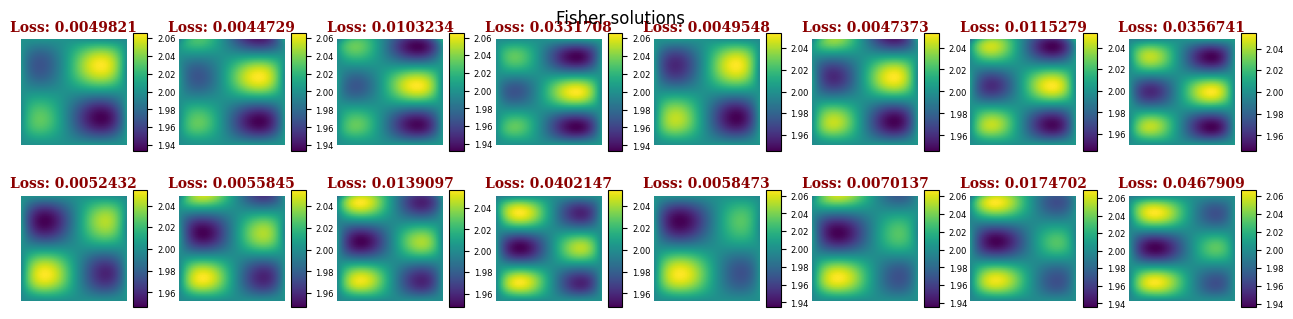

In [21]:
plot_solutions16(perturbation_list, 'Fisher solutions', 
                subtitle_list = ["Loss: " + str(round(l['total_loss'], 7)) for l in Fisher_loss_list]);

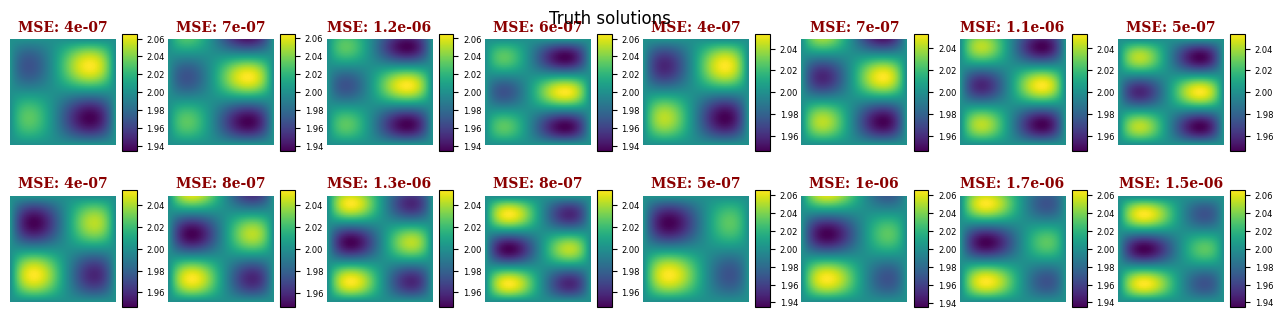

In [22]:
plot_solutions16(manufactured_list, 'Truth solutions', subtitle_list = ["MSE: " + str(round(mse, 7)) for mse in mse_list]);

In [23]:
##print 1. mean fisher loss 2. mean relative pde residual 3. mean BC condition loss 4. mean relative error
print("Average Fisher's Loss: ", np.mean([l['total_loss'] for l in Fisher_loss_list]))
print("Average Relative PDE residual diff: ", np.mean([l['relative_pde_loss'] for l in Fisher_loss_list]))
print("Average Relative BC loss: ", np.mean([l['relative_bc_loss'] for l in Fisher_loss_list]))
relative_error = abs(np.array(perturbation_list) - np.array(manufactured_list)).mean()/abs(np.array(manufactured_list)).mean()
print("Mean relative error: ", relative_error)

Average Fisher's Loss:  0.015744842387469586
Average Relative PDE residual diff:  0.03953404965910794
Average Relative BC loss:  9.377563027786594e-07
Mean relative error:  0.0003123200916623111


In [24]:
print("Mean MSE: ", np.mean(mse_list))

Mean MSE:  8.514969470446889e-07


In [25]:
indices = [0, 1, 2, 3, 12, 13, 14, 15]
TL_solution = np.array(perturbation_list)[indices]
truth_solution = np.array(manufactured_list)[indices]

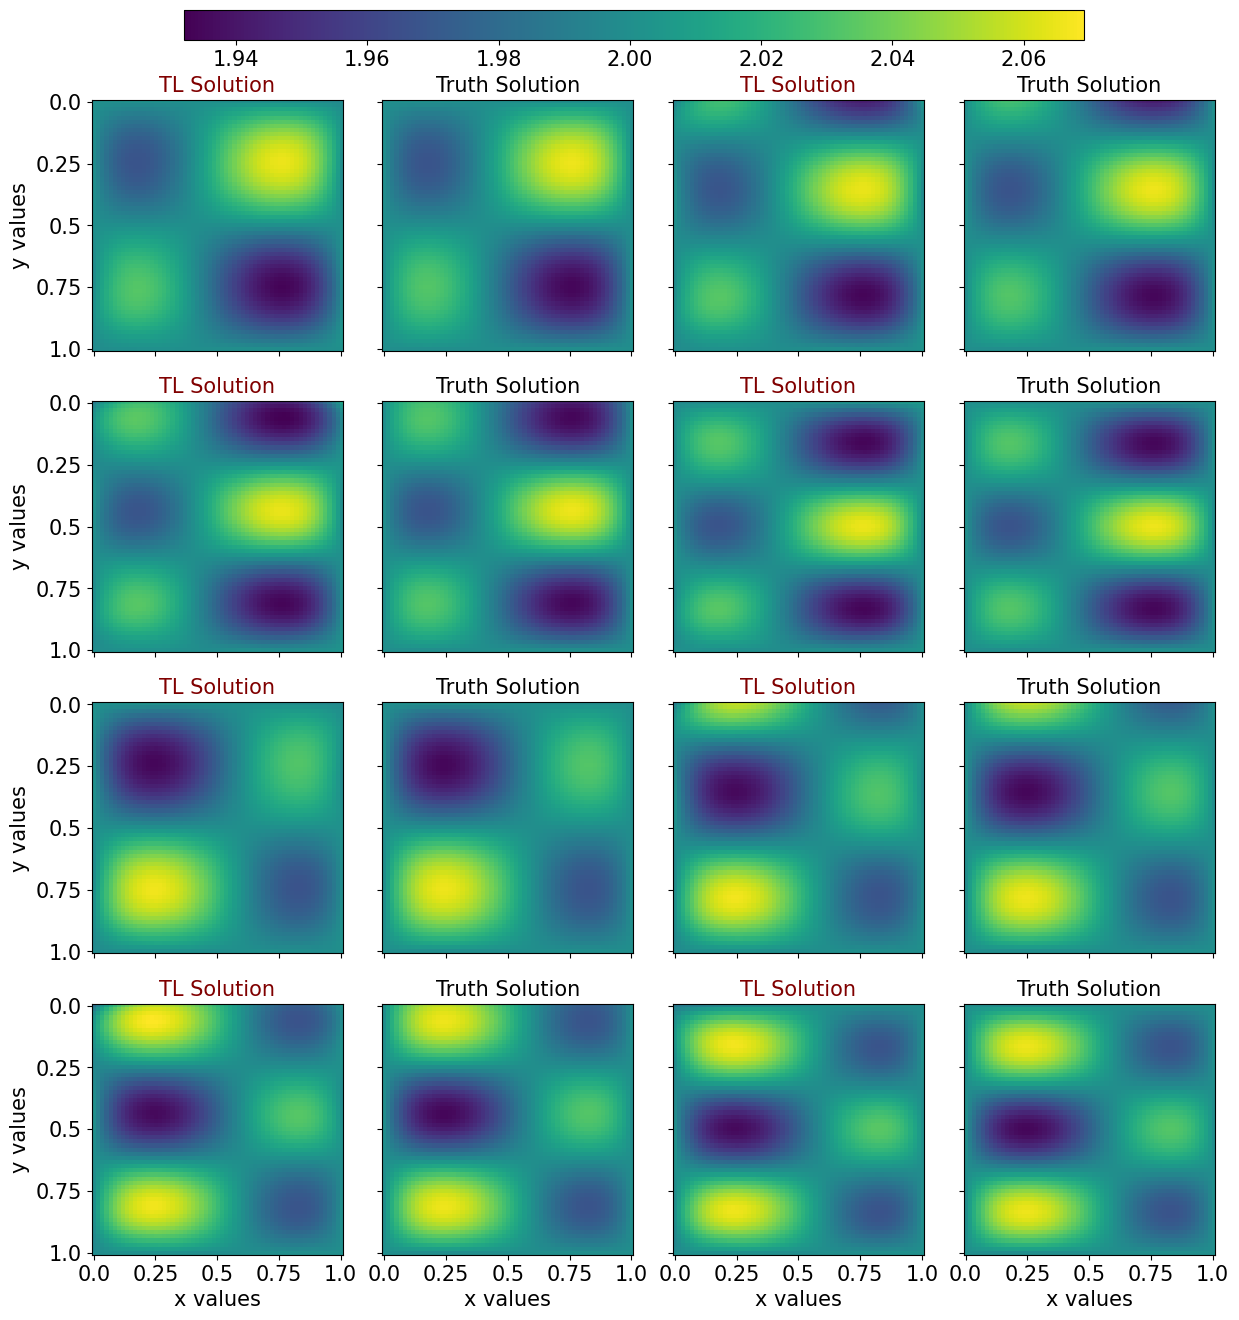

In [26]:
fig, ax = plt.subplots(4, 4, figsize=(15, 15), sharex = True, sharey=True);
# Create color map
cmap = plt.get_cmap('viridis');  # You can choose any colormap you prefer
# Create colorbar
global_min = min(min([result.min() for result in TL_solution]), min([result.min() for result in truth_solution]))
global_max = max(max([result.max() for result in TL_solution]), max([result.max() for result in truth_solution]))
normalizer = Normalize(global_min, global_max)
im = cm.ScalarMappable(norm=normalizer)

for i, tl in enumerate(TL_solution):
    j = i//2; k = 2*(i%2)
    ax[j][k].imshow(tl[::-1, :], cmap=cmap, norm=normalizer)
    ax[j][k].set_title("TL Solution", fontsize=15, color='maroon');
    ax[j][k].set_xticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5), fontsize=15)
    ax[j][k].set_yticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5), fontsize=15)
for i, truth in enumerate(truth_solution):
    j = i//2; k = 2*(i%2)+1
    ax[j][k].imshow(truth[::-1, :], cmap=cmap, norm=normalizer)
    ax[j][k].set_title("Truth Solution", fontsize=15);
    ax[j][k].set_xticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5), fontsize=15)
    ax[j][k].set_yticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5), fontsize=15)

# Create a color bar axis
cax = fig.add_axes([0.2, 0.92, 0.6, 0.02])  # [left, bottom, width, height]
# Create the color bar
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.0)

for i in range(4):
    ax[3][i].set_xlabel('x values', fontsize=15)
    ax[i][0].set_ylabel('y values', fontsize=15)

plt.savefig('Fisher_result.png',dpi=500, bbox_inches='tight')

In [27]:
mse_p = []
fisher_p = []
for p in tqdm(range(1, 45)):
    zeta_list = np.linspace(0.4, 0.6, 4)
    K_list = np.linspace(2*np.pi, 3*np.pi, 4)
    b = 2; r = 0.8; A = 1;
    manufactured_list = []
    perturbation_list = []
    Fisher_loss_list = []
    mse_list = []
    
    for zeta in zeta_list:
        for k in K_list:
            ##compute the Perturbation solutions
            force = forcing_decorator4(A, zeta, k, r, b=b)
            f0_values = force(x, t).detach().numpy()
            result = Fisher_solver(H_dict, Minv, f0_values, b, r, H, p=p)
            perturbation_list.append(result['sol'])
            ##compute the truth solutions
            truth_func = function_decorator4(A, zeta, k, b=b)
            truth = truth_func(X_grid[:,0], X_grid[:, 1]).reshape(61, -1).detach().numpy()
            manufactured_list.append(truth)
            ##compute mse for each one
            mse_list.append(((truth - result['sol'])**2).mean())
            ##compute the Fisher loss
            Fisher_loss_list.append(Fisher_loss(model, result['W'], r, force, b0=b))
    fisher_p.append(np.mean([result['total_loss'] for result in Fisher_loss_list]))
    mse_p.append(np.mean(mse_list))

  0%|          | 0/44 [00:00<?, ?it/s]

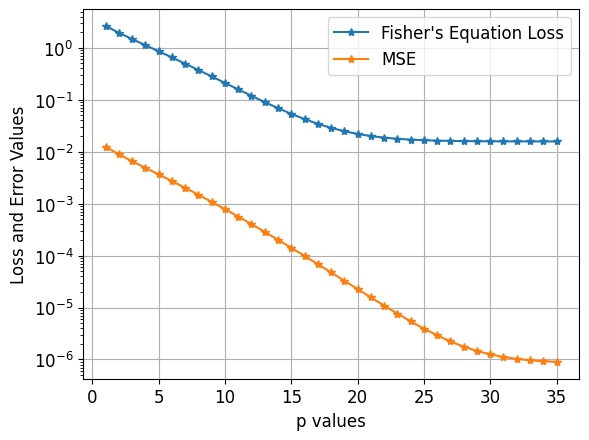

In [66]:
plt.plot(range(1, 36), fisher_p[:35], '*-', label="Fisher's Equation Loss");
plt.plot(range(1, 36), mse_p[:35], '*-', label='MSE');
plt.yscale('log');
plt.grid();
plt.legend(fontsize=12);
plt.xlabel('p values', fontsize=12);
plt.ylabel('Loss and Error Values', fontsize=12);
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

plt.savefig('Fisher_p_compare.png',dpi=500, bbox_inches='tight')

In [28]:
zeta_list = np.linspace(0.4, 0.6, 10)
K_list = np.linspace(2*np.pi, 3*np.pi, 10)
p = 35; b = 2; r = 0.8; A = 1;
manufactured_list = []
perturbation_list = []
Fisher_loss_list = []
mse_list = []

s = time.time()
for zeta in zeta_list:
    for k in K_list:
        ##compute the Perturbation solutions
        force = forcing_decorator4(A, zeta, k, r, b=b)
        f0_values = force(x, t).detach().numpy()
        result = Fisher_solver(H_dict, Minv, f0_values, b, r, H, p=p)
e = time.time()
print((e-s)/100, " seconds per solve")

0.16434900999069213  seconds per solve


### For Better Visualization 

In [29]:
difference = TL_solution - truth_solution

In [30]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

def float_to_scientific_notation(num):
    """Transform a float to its scientific notation string representation."""
    result = "{:.1e}".format(num)
    result2 = result[:-2]
    result2 += result[-1]
    return result2

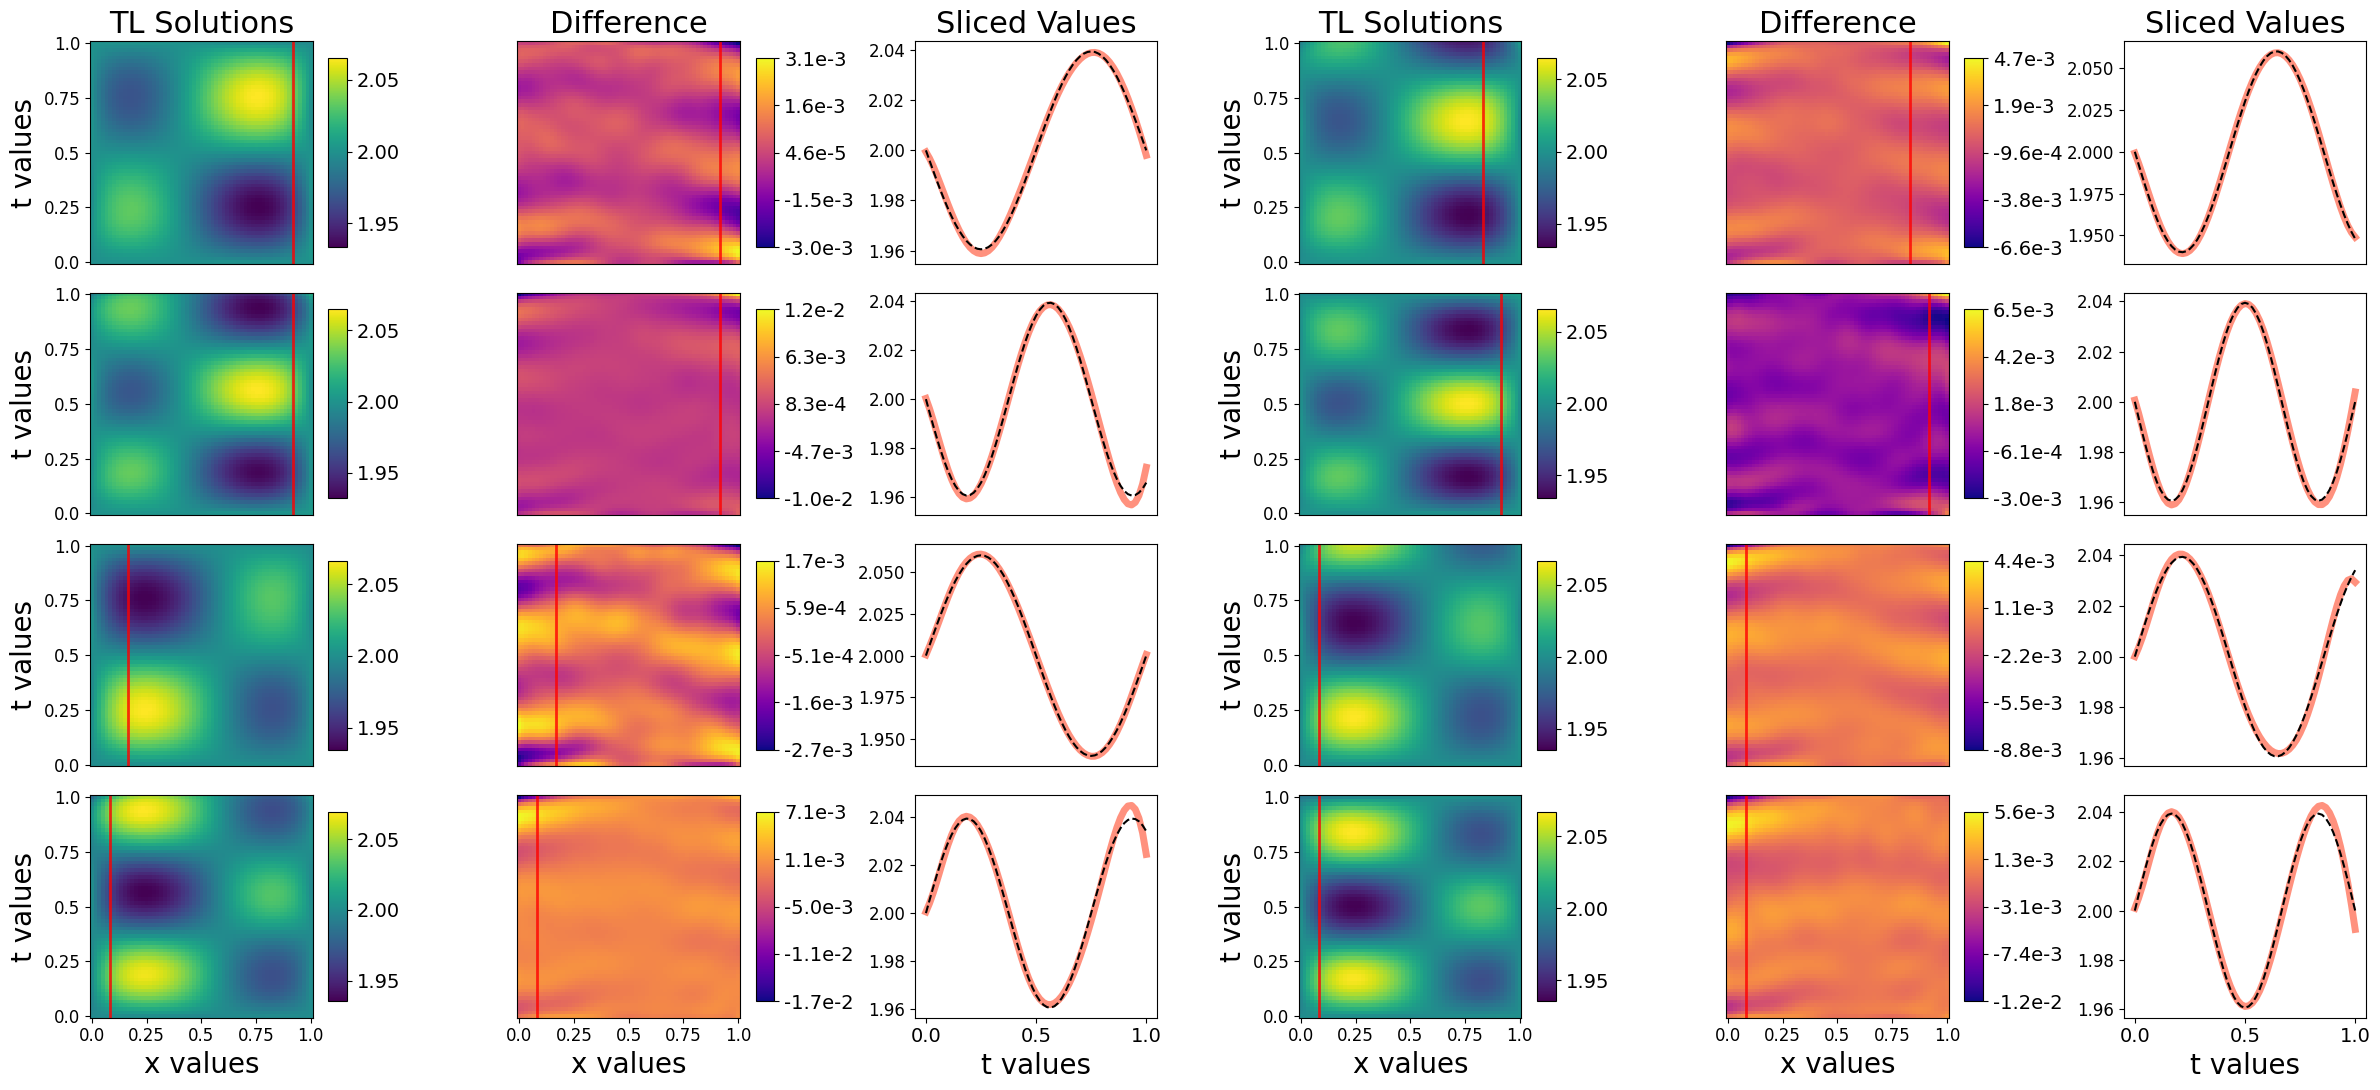

In [31]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(4, 6, figsize=(24, 11), 
        gridspec_kw={'width_ratios': [1.3, 1.3, 1, 1.3, 1.3, 1], 'height_ratios': [1.2, 1.2, 1.2, 1.2]});
plt.subplots_adjust(wspace=0, hspace=-.2)
sample_indices = [55, 50, 55, 55, 10, 5, 5, 5]
for i, sol in enumerate(TL_solution):
    j = i//2; k = (i%2)*3
    im1 = ax[j][k].imshow(sol[::-1, :]) # plot the TL solution 
    im2 = ax[j][k+1].imshow(difference[i][::-1, :], cmap='plasma') # plot the difference

    ax[j][k].set_xticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5), fontsize=12)
    ax[j][k].set_yticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5)[::-1], fontsize=12)
    ax[j][k+1].set_xticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5), fontsize=12)
    ax[j][k+1].set_yticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5)[::-1], fontsize=12)

    if j == 3:
        ax[j][k].set_xlabel('x values', fontsize=20)
        ax[j][k+1].set_xlabel('x values', fontsize=20)
    
    # Add a colorbar to the subplot
    pad=0.05
    cbar1 = fig.colorbar(im1, ax=ax[j][k], orientation='vertical', shrink=0.85, aspect=10, pad=pad)
    cbar2 = fig.colorbar(im2, ax=ax[j][k+1], orientation='vertical', shrink=0.85, aspect=10, pad=pad, 
                        ticks=np.linspace(difference[i].min(), difference[i].max(), num=5))
    
    cbar1.ax.tick_params(labelsize=14)
    cbar2.ax.tick_params(labelsize=14)
    cbar2.set_ticklabels([float_to_scientific_notation(s) for s in np.linspace(difference[i].min(), difference[i].max(), num=5)])
    

    ##plot vertical line 
    ax[j][k].axvline(sample_indices[i], c='red', alpha=.8, lw=2)
    ax[j][k+1].axvline(sample_indices[i], c='red', alpha=.8, lw=2)

    #plot the sliced function values
    y_values = np.linspace(0, 1, 61)
    ax[j][k+2].plot(y_values, sol[:,sample_indices[i]], c='tomato', lw=5, alpha=.7)
    ax[j][k+2].plot(y_values, truth_solution[i][:,sample_indices[i]], '--', c='black', lw=1.5)
    #ax[j][k+2].set_ylabel('Solution Value', fontsize=12);
    ax[j][k+2].tick_params(axis='y', labelsize=12)
    
    if j!=3:
        ax[j][k+2].set_xticks([]);
    else:
        ax[j][k+2].set_xlabel("t values", fontsize=20);
        ax[j][k+2].tick_params(axis='x', labelsize=14)

for j in range(3):
    ax[j][0].set_xticks([]); ax[j][1].set_xticks([]); ax[j][3].set_xticks([]); ax[j][4].set_xticks([])
for j in range(4):
    ax[j][1].set_yticks([]); ax[j][4].set_yticks([]);
    ax[j][0].set_ylabel('t values', fontsize=20);
    ax[j][3].set_ylabel('t values', fontsize=20);
    
ax[0][0].set_title("TL Solutions", fontsize=22); ax[0][3].set_title("TL Solutions", fontsize=22);
ax[0][1].set_title("Difference", fontsize=22); ax[0][4].set_title("Difference", fontsize=22);
ax[0][2].set_title("Sliced Values", fontsize=22); ax[0][5].set_title("Sliced Values", fontsize=22)

plt.tight_layout()
plt.savefig('Fisher_result_new.png',dpi=500, bbox_inches='tight')

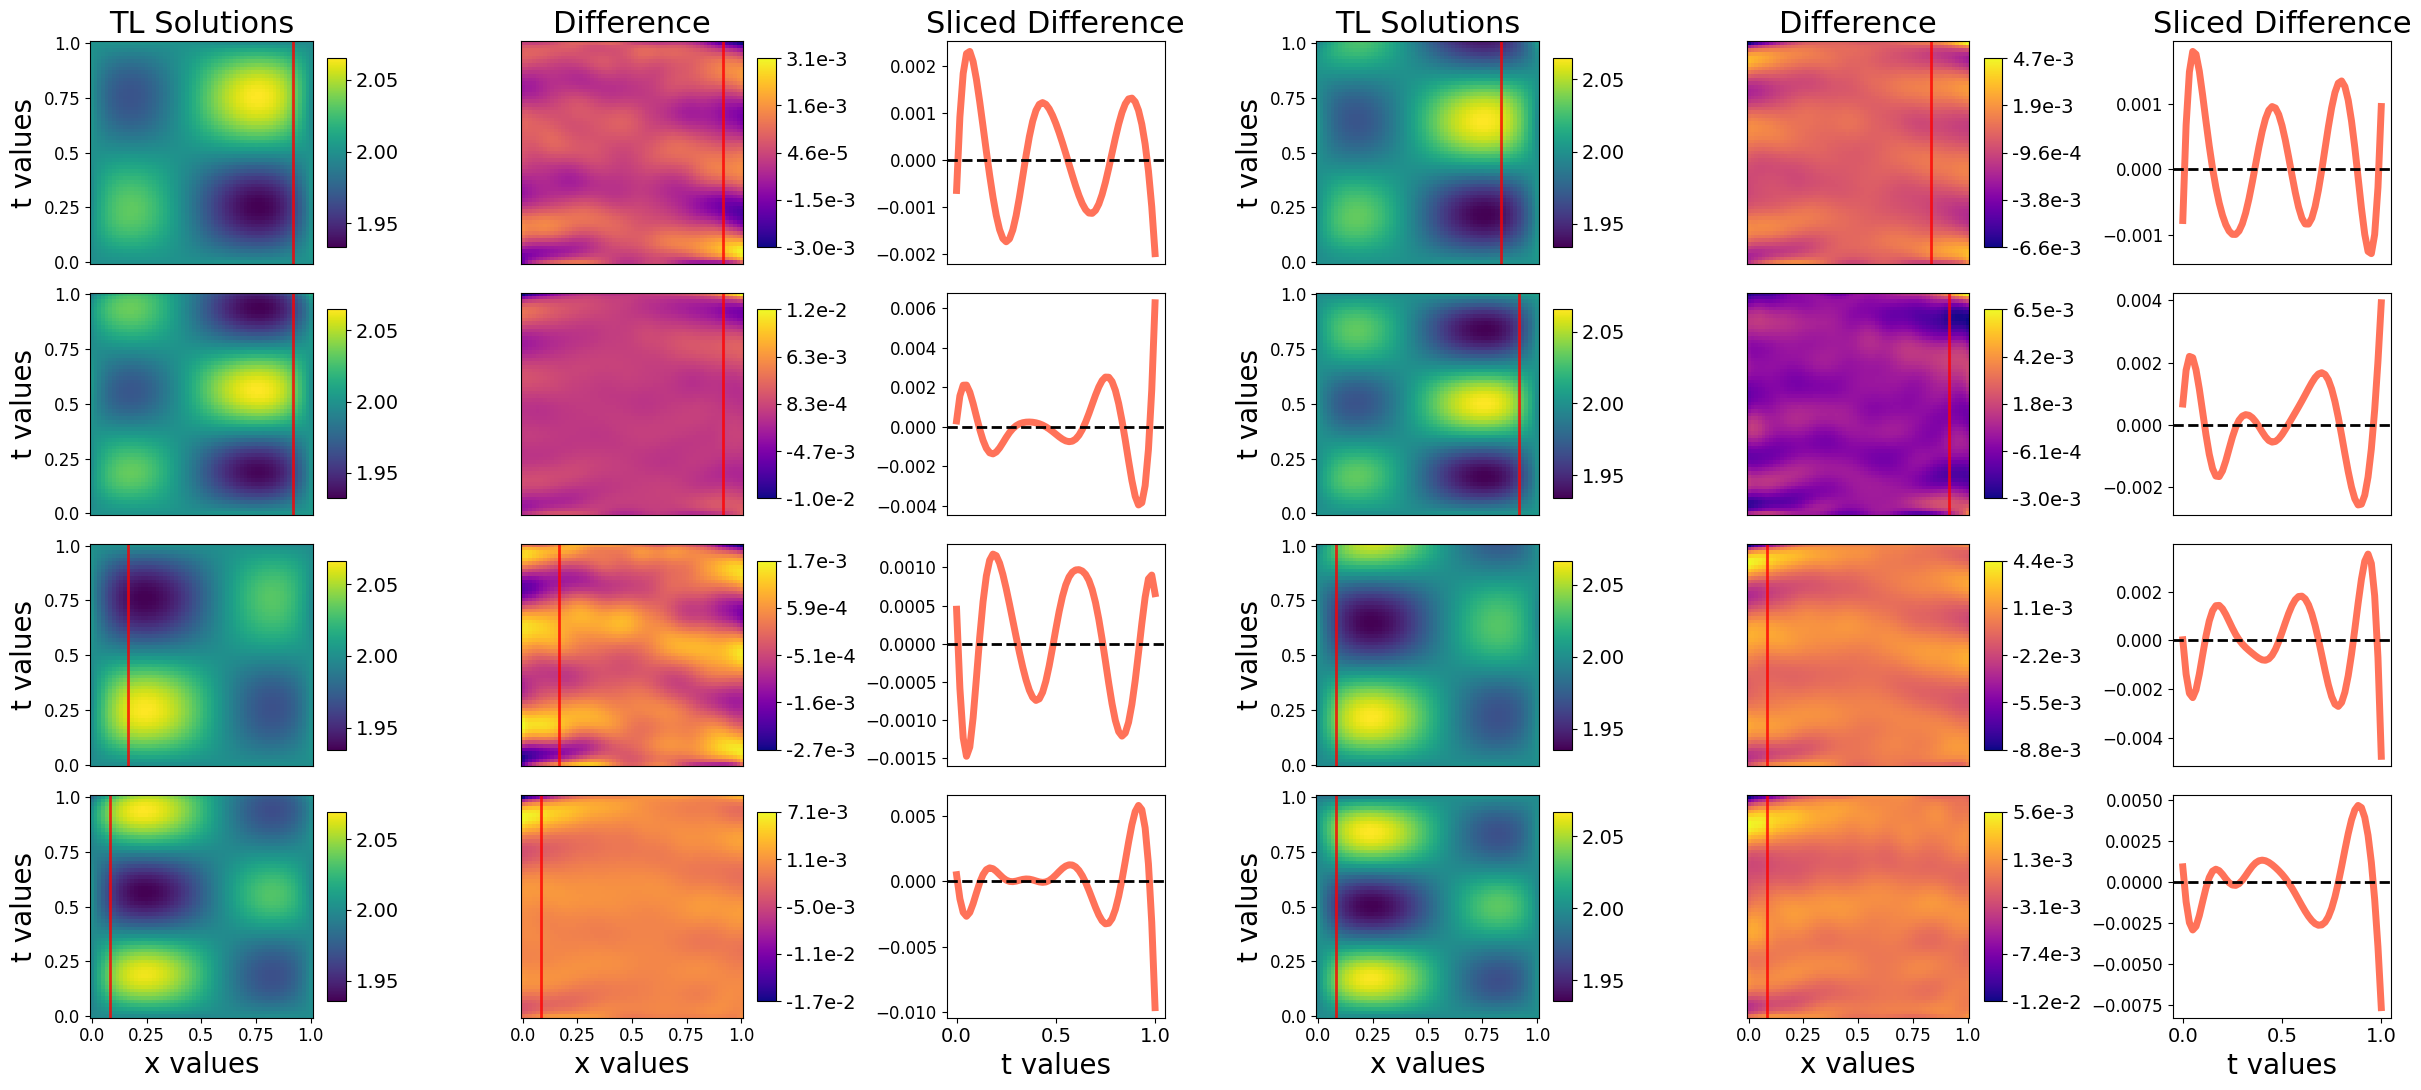

In [32]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(4, 6, figsize=(24, 11), 
        gridspec_kw={'width_ratios': [1.3, 1.3, 1, 1.3, 1.3, 1], 'height_ratios': [1.2, 1.2, 1.2, 1.2]});
plt.subplots_adjust(wspace=0, hspace=-.2)
sample_indices = [55, 50, 55, 55, 10, 5, 5, 5]
for i, sol in enumerate(TL_solution):
    j = i//2; k = (i%2)*3
    im1 = ax[j][k].imshow(sol[::-1, :]) # plot the TL solution 
    im2 = ax[j][k+1].imshow(difference[i][::-1, :], cmap='plasma') # plot the difference

    ax[j][k].set_xticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5), fontsize=12)
    ax[j][k].set_yticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5)[::-1], fontsize=12)
    ax[j][k+1].set_xticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5), fontsize=12)
    ax[j][k+1].set_yticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5)[::-1], fontsize=12)

    if j == 3:
        ax[j][k].set_xlabel('x values', fontsize=20)
        ax[j][k+1].set_xlabel('x values', fontsize=20)
    
    # Add a colorbar to the subplot
    pad=0.05
    cbar1 = fig.colorbar(im1, ax=ax[j][k], orientation='vertical', shrink=0.85, aspect=10, pad=pad)
    cbar2 = fig.colorbar(im2, ax=ax[j][k+1], orientation='vertical', shrink=0.85, aspect=10, pad=pad, 
                        ticks=np.linspace(difference[i].min(), difference[i].max(), num=5))
    
    cbar1.ax.tick_params(labelsize=14)
    cbar2.ax.tick_params(labelsize=14)
    cbar2.set_ticklabels([float_to_scientific_notation(s) for s in np.linspace(difference[i].min(), difference[i].max(), num=5)])
    

    ##plot vertical line 
    ax[j][k].axvline(sample_indices[i], c='red', alpha=.8, lw=2)
    ax[j][k+1].axvline(sample_indices[i], c='red', alpha=.8, lw=2)

    #plot the sliced function values
    y_values = np.linspace(0, 1, 61)
    ax[j][k+2].plot(y_values, difference[i][:,sample_indices[i]], c='tomato', lw=5, alpha=.9)
    ax[j][k+2].axhline(0, ls='--', c='black', lw=2)
    
    ax[j][k+2].tick_params(axis='y', labelsize=12)
    
    if j!=3:
        ax[j][k+2].set_xticks([]);
    else:
        ax[j][k+2].set_xlabel("t values", fontsize=20);
        ax[j][k+2].tick_params(axis='x', labelsize=14)

for j in range(3):
    ax[j][0].set_xticks([]); ax[j][1].set_xticks([]); ax[j][3].set_xticks([]); ax[j][4].set_xticks([])
for j in range(4):
    ax[j][1].set_yticks([]); ax[j][4].set_yticks([]);
    ax[j][0].set_ylabel('t values', fontsize=20);
    ax[j][3].set_ylabel('t values', fontsize=20);
    
ax[0][0].set_title("TL Solutions", fontsize=22); ax[0][3].set_title("TL Solutions", fontsize=22);
ax[0][1].set_title("Difference", fontsize=22); ax[0][4].set_title("Difference", fontsize=22);
ax[0][2].set_title("Sliced Difference", fontsize=22); ax[0][5].set_title("Sliced Difference", fontsize=22)

plt.tight_layout()

In [33]:
increasing_performance = (difference**2).mean(axis=1).mean(axis=1).argsort()[::-1]
increasing_performance

array([6, 7, 2, 5, 1, 3, 4, 0])

In [34]:
print("Min difference: ", difference.min())
print("Max Difference: ", difference.max())

Min difference:  -0.01718240628888612
Max Difference:  0.01179925512591451


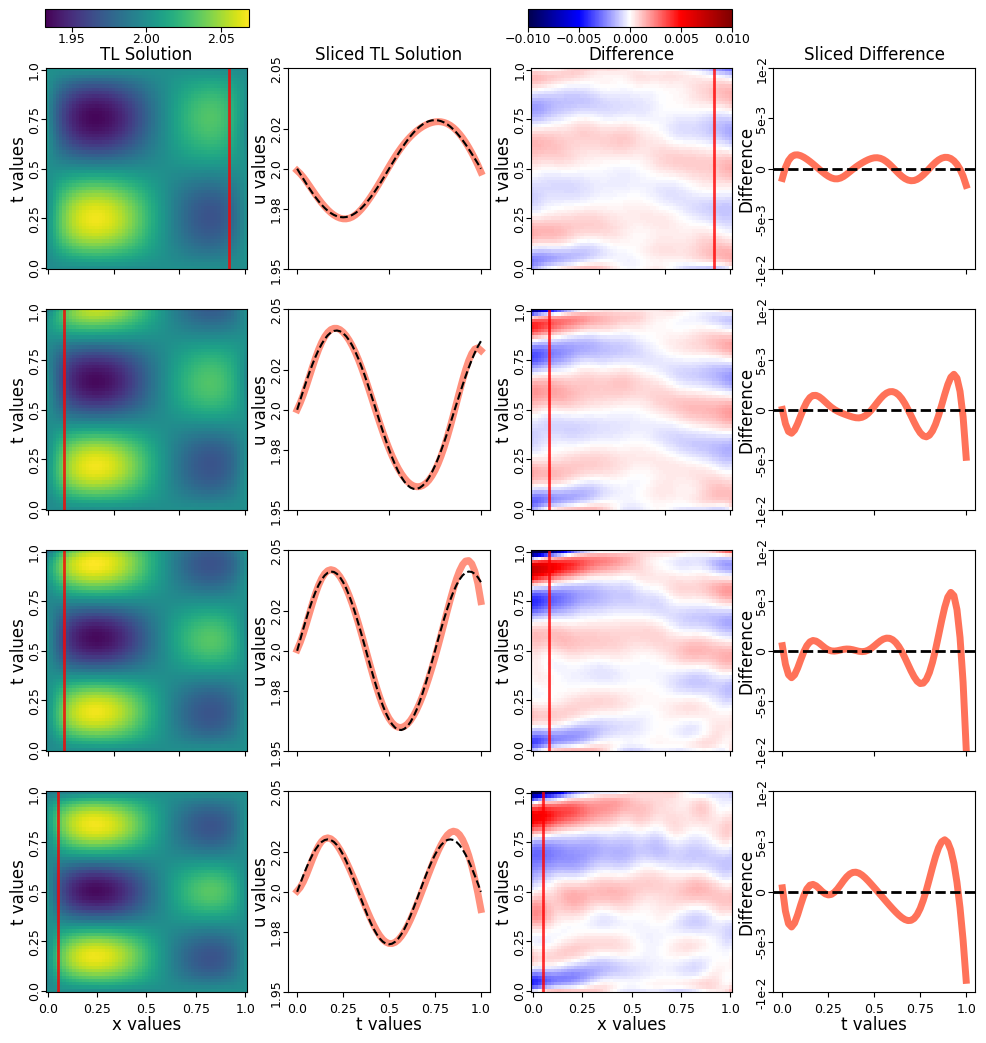

In [139]:
fig, ax = plt.subplots(4, 4, figsize=(12, 12), 
        gridspec_kw={'width_ratios': [1, 1, 1, 1], 'height_ratios': [1, 1, 1, 1]});
sample_indices = [55, 5, 5, 3]
reorder = [4, 5, 6, 7]

# Create color map
cmap1 = plt.get_cmap('viridis');  # You can choose any colormap you prefer
# Create colorbar
global_min = min([result.min() for result in TL_solution])
global_max = max([result.max() for result in TL_solution])
normalizer1 = Normalize(global_min, global_max)
im1 = cm.ScalarMappable(norm=normalizer1, cmap=cmap1)

cmap2 = plt.get_cmap('seismic');  
normalizer2 = Normalize(-0.01, 0.01)
im2 = cm.ScalarMappable(norm=normalizer2, cmap=cmap2)

label_fontsize = 12

for i, sol in enumerate(TL_solution[reorder, :, :]):
    #plot the TL solutions and the differences
    ax[i][0].imshow(sol[::-1, :], cmap=cmap1, norm=normalizer1) # plot the TL solution 
    ax[i][2].imshow(difference[reorder, :, :][i][::-1, :], cmap=cmap2, norm=normalizer2) # plot the difference

    #plot the vertical sample slice line
    ax[i][0].axvline(sample_indices[i], c='red', alpha=.8, lw=2)
    ax[i][2].axvline(sample_indices[i], c='red', alpha=.8, lw=2)

    #plot the sliced function values
    y_values = np.linspace(0, 1, 61)
    ax[i][1].plot(y_values, sol[:,sample_indices[i]], c='tomato', lw=5, alpha=.7)
    ax[i][1].plot(y_values, truth_solution[reorder, :, :][i][:,sample_indices[i]], '--', c='black', lw=1.5)

    #plot the sliced differences
    ax[i][3].plot(y_values, difference[reorder, :, :][i][:,sample_indices[i]], c='tomato', lw=5, alpha=.9)
    ax[i][3].axhline(0, ls='--', c='black', lw=2)
    ax[i][3].set_ylim(-0.01, 0.01)

    if i == 3:
        ax[i][0].set_xticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5), fontsize=9);
        ax[i][0].set_xlabel("x values", fontsize=label_fontsize, labelpad=0);

        ax[i][1].set_xticks(np.linspace(0, 1, 5), np.linspace(0, 1, 5), fontsize=9);
        ax[i][1].set_xlabel("t values", fontsize=label_fontsize, labelpad=0);

        ax[i][2].set_xticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5), fontsize=9);
        ax[i][2].set_xlabel("x values", fontsize=label_fontsize, labelpad=0);

        ax[i][3].set_xticks(np.linspace(0, 1, 5), np.linspace(0, 1, 5), fontsize=9);
        ax[i][3].set_xlabel("t values", fontsize=label_fontsize, labelpad=0);
    else:
        for j in range(4):
            ax[i][j].set_xticklabels([]);
            ax[i][j].set_xlabel('');

    ax[i][0].set_yticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5)[::-1], fontsize=9);
    ax[i][2].set_yticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5)[::-1], fontsize=9);
    ax[i][0].set_ylabel('t values', fontsize=label_fontsize, labelpad=0);
    ax[i][2].set_ylabel('t values', fontsize=label_fontsize, labelpad=0);
    ax[i][1].set_yticks([round(val, 2) for val in np.linspace(1.95, 2.05, 5)], 
                        [round(val, 2) for val in np.linspace(1.95, 2.05, 5)], fontsize=9);
    ax[i][3].set_yticks(np.linspace(-0.01, 0.01, 5), 
                        ['-1e-2', '-5e-3', '0', '5e-3', '1e-2'], fontsize=9);
    ax[i][1].set_ylabel('u values', fontsize=label_fontsize, labelpad=0);
    ax[i][3].set_ylabel('Difference', fontsize=label_fontsize, labelpad=0);
    
    for j in range(4):
        ax[i][j].tick_params(axis='y', labelrotation=90, pad=.1)
        for label in ax[i][j].get_yticklabels():
            label.set_verticalalignment('center')

    
    
# Create a color bar axis
cax1 = fig.add_axes([0.125, 0.914, 0.17, 0.015])  # [left, bottom, width, height]
cbar1 = fig.colorbar(im1, ax=ax.ravel().tolist(), cax=cax1, orientation='horizontal')
cbar1.ax.tick_params(labelsize=9); cbar1.ax.tick_params(pad=0)

cax2 = fig.add_axes([0.527, 0.914, 0.17, 0.015])  # [left, bottom, width, height]
cbar2 = fig.colorbar(im2, ax=ax.ravel().tolist(), cax=cax2, orientation='horizontal')
cbar2.ax.tick_params(labelsize=9); cbar2.ax.tick_params(pad=0)

ax[0][0].set_title("TL Solution");
ax[0][1].set_title("Sliced TL Solution");
ax[0][2].set_title("Difference");
ax[0][3].set_title("Sliced Difference");

plt.savefig('Fisher_result2.png',dpi=500, bbox_inches='tight')